In [50]:
# Required imports for this section (ensure they are imported at the top of your script)
import pandas as pd
import numpy as np
import folium
import branca # Needed for custom Folium legends
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from sklearn.cluster import KMeans
import networkx as nx
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from scipy.special import expit  # Numerically stable sigmoid function
import statsmodels.api as sm


num_quantiles = 10  # Number of quantiles for centrality
year = 2017


df = pd.read_csv('../data/processed/cost_data.csv')
df = df[df['Year'] == year]
df = df.reset_index(drop=True)

simulated_yard_data = pd.read_parquet('../data/processed/simulations/yard_data_apr3.parquet')
simulated_yard_data = simulated_yard_data[simulated_yard_data['Year'] == year]
simulated_yard_data = simulated_yard_data.reset_index(drop=True)

# If simulated_yard_data['Variety'] == 'nugget' or 'mosaic' then set value in new column 'tI1' to 1, else set to 0
simulated_yard_data['tI1'] = np.where(simulated_yard_data['Variety'].isin(['nugget', 'mosaic']), 1, 0)
simulated_yard_data['tI1'] = simulated_yard_data['tI1'].astype(np.int32)

# If simulated_yard_data['Variety'] == 'nugget' or 'mosaic' then set value in new column 'tI1' to 1, else set to 0
simulated_yard_data['tI2'] = np.where(simulated_yard_data['Variety'].isin(['chinook', 'simcoe']), 1, 0)
simulated_yard_data['tI2'] = simulated_yard_data['tI2'].astype(np.int32)

tI1 = simulated_yard_data['tI1'].values.reshape(-1, 1)
tI2 = simulated_yard_data['tI2'].values.reshape(-1, 1)

# Filter the DataFrame to include only the relevant columns
real_yard_data = df[['Field ID', 'Year', 'Centroid Lat', 'Centroid Long', 'Grower', 'Variety', 'Initial Strain']].copy()

period = ['may-jun', 'jun-jul']

# Import data
if year == 2014:
    X = np.load('../data/processed/data_2014.npz')

elif year == 2015:
    X = np.load('../data/processed/data_2015.npz')

elif year == 2016:
    X = np.load('../data/processed/data_2016.npz')

elif year == 2017:
    X = np.load('../data/processed/data_2017.npz')

N = int(X['N'])

distance = X['distance']
dist = X['distance']
# tI1 = X['tI1'].reshape(N,1)
# tI2 = X['tI2'].reshape(N,1)
sI2 = X['sI2'].reshape(N,1)

y_apr = X['y_apr'].reshape(N,1)
y_may = X['y_may'].reshape(N,1)
y_jun = X['y_jun'].reshape(N,1)
y_jul = X['y_jul'].reshape(N,1)

n_apr = X['n_apr'].reshape(N,1)
n_may = X['n_may'].reshape(N,1)
n_jun = X['n_jun'].reshape(N,1)
n_jul = X['n_jul'].reshape(N,1)

area_apr = X['a_apr'].reshape(N,1)
a_apr = X['a_apr'].reshape(N,1)
a_may = X['a_may'].reshape(N,1)
a_jun = X['a_jun'].reshape(N,1)
a_jul = X['a_jul'].reshape(N,1)

w_apr = X['wind_apr']
w_may = X['wind_may']
w_jun = X['wind_jun']
w_jul = X['wind_jul']

sI1_apr = X['sI1_apr'].reshape(N,1)
sI1_may = X['sI1_may'].reshape(N,1)
sI1_jun = X['sI1_jun'].reshape(N,1)
sI1_jul = X['sI1_jul'].reshape(N,1)

s_apr = X['s_apr'].reshape(N,1)
s_may = X['s_may'].reshape(N,1)
s_jun = X['s_jun'].reshape(N,1)
s_jul = X['s_jul'].reshape(N,1)

# Convert to float64
dist = dist.astype(np.float64)
# tI1 = tI1.astype(np.float64)
# tI2 = tI2.astype(np.float64)
sI2 = sI2.astype(np.float64)

y_apr = y_apr.astype(np.float64)
y_may = y_may.astype(np.float64)
y_jun = y_jun.astype(np.float64)
y_jul = y_jul.astype(np.float64)

n_apr = n_apr.astype(np.float64)
n_may = n_may.astype(np.float64)
n_jun = n_jun.astype(np.float64)
n_jul = n_jul.astype(np.float64)

a_apr = a_apr.astype(np.float64)
a_may = a_may.astype(np.float64)
a_jun = a_jun.astype(np.float64)
a_jul = a_jul.astype(np.float64)

w_apr = w_apr.astype(np.float64)
w_may = w_may.astype(np.float64)
w_jun = w_jun.astype(np.float64)
w_jul = w_jul.astype(np.float64)

sI1_apr = sI1_apr.astype(np.float64)
sI1_may = sI1_may.astype(np.float64)
sI1_jun = sI1_jun.astype(np.float64)
sI1_jul = sI1_jul.astype(np.float64)

s_apr = s_apr.astype(np.float64)
s_may = s_may.astype(np.float64)
s_jun = s_jun.astype(np.float64)
s_jul = s_jul.astype(np.float64)

area_hectares = a_apr

# Specify the number of plants in each yard. Here we assume 400 plants per yard
n = (np.ones((N, 1)) * 400).astype(np.int32)

# Import Parameters
theta_may_jun = np.load('../reports/parameters/theta_may-jun_power_oct25.npy', allow_pickle=True)
theta_jun_jul = np.load('../reports/parameters/theta_jun-jul_power_oct25.npy', allow_pickle=True)

def eta(period, y_lag, sprays):

    y_lag = y_lag
    n_lag = n
    s_lag = sprays

    if period == 'may-jun':
        theta = theta_may_jun
        a_lag = a_may
        w_lag = w_may
        
    elif period == 'jun-jul':
        theta = theta_jun_jul
        a_lag = a_jun
        w_lag = w_jun

    beta1, beta2, delta1, delta2, gamma1, gamma2, alpha1, alpha2, eta11, eta12, eta21, eta22 = theta

    beta1_array = np.full((N,1), beta1)
    beta2_array = np.full((N,1), beta2)

    auto_infection1 = delta1 * (y_lag / n_lag) * np.exp(-eta11 * s_lag)
    auto_infection2 = delta2 * (y_lag / n_lag) * np.exp(-eta12 * s_lag)

    dispersal1 = []
    dispersal2 = []

    eta_1 = []

    for i in range(0, N):

        dispersal_array = ((a_lag * (y_lag / n_lag)) * (w_lag[:, i].reshape(N,1)))
        dispersal_array1 = dispersal_array * np.exp(-eta21 * s_lag) * np.power(1 + dist[:, i].reshape(N,1), -alpha1) * sI1_lag
        dispersal_array2 = dispersal_array * np.exp(-eta22 * s_lag) * np.power(1 + dist[:, i].reshape(N,1), -alpha2) * sI2
        dispersal_component1_i = gamma1 * (np.sum(dispersal_array1) - dispersal_array1[i][0])
        dispersal_component2_i = gamma2 * (np.sum(dispersal_array2) - dispersal_array2[i][0])

        dispersal1.append(dispersal_component1_i)
        dispersal2.append(dispersal_component2_i)

    dispersal1 = np.array(dispersal1).reshape(N,1)
    dispersal2 = np.array(dispersal2).reshape(N,1)

    eta = tI1 * (beta1_array + auto_infection1 + dispersal1) + tI2 * (beta2_array + auto_infection2 + dispersal2)

    # eta_1_i = tI1[i] * (auto_infection1 + dispersal1) + tI2[i] * (auto_infection2 + dispersal2)
    eta_1_i = (auto_infection1 + dispersal1) + (auto_infection2 + dispersal2)
    eta_1.append(eta_1_i)
    eta_1 = np.array(eta_1).reshape(N,1)

    return eta, eta_1

# Probability Function

def prob(period, y_lag, sprays):

    etaa = eta(period, y_lag, sprays)

    p = expit(etaa[0])

    for i in range(0, N):

        if etaa[1][i] == 0.0:
            p[i] = 0.0

    return p

In [51]:
print(theta_jun_jul)

np.set_printoptions(precision=2, suppress=True)

[[  -2.785954493 ]
 [  -3.8837032423]
 [   2.938782895 ]
 [   8.0439297571]
 [1390.7076209352]
 [ 286.8022464531]
 [   1.0006846315]
 [   2.0400502763]
 [   0.0238317252]
 [   0.308224747 ]
 [   0.9494636118]
 [   0.3651273522]]


In [52]:
# DISTANCE BASED NETWORK

# Create a linear gradient colormap from blue to red

cmap = LinearSegmentedColormap.from_list('centrality_colormap', ['blue', 'yellow', 'red'], N=num_quantiles)

cmap = LinearSegmentedColormap.from_list('approx_inferno', [
    '#FCFFA4',  # Yellow
    '#FCA50A',  # Orange
    '#DD513A',  # Red-orange
    '#932567',  # Dark red
    '#420A68',  # Purple
    '#000004'   # Black
], N=num_quantiles)

# Centroid Latitude and Longitude Coordinates
coord = df[(df['Month'] == 'May')][['Centroid Lat', 'Centroid Long']].reset_index(drop=True)

# Calculate average wind run (ensure this aligns with your data structure)
avg_wind_run = (w_may + w_jun) / 2

# Initialize a DIRECTED graph
G = nx.DiGraph()

# Add nodes with their coordinates
print("Adding nodes...")
for index, row in coord.iterrows():
    G.add_node(index, pos=(row['Centroid Long'], row['Centroid Lat']))
print(f"Added {G.number_of_nodes()} nodes.")


# Add DIRECTED edges with weights using the formula
print("Adding directed edges...")
for i in G.nodes():
    for j in G.nodes():
        if i == j:
            continue # Skip self-loops

        # --- Calculate weight for edge i -> j ---
        try:
            # Access scalar value using [i, 0] for (N, 1) arrays
            area_i = area_apr[i, 0]
            wind_run_ij = avg_wind_run[i, j] # Assumes avg_wind_run is (N, N)
            distance_ij = distance[i, j]   # Assumes distance is (N, N)

            weight_ij = area_i * wind_run_ij * np.power(1 + distance_ij, -2)

            if weight_ij > 1e-9:
                G.add_edge(i, j, weight=weight_ij)

        except IndexError:
            print(f"Warning: Index out of bounds for edge {i} -> {j}. Check array dimensions (N={N}). Skipping.")
            continue

        # --- Calculate weight for edge j -> i ---
        try:
            # Access scalar value using [j, 0] for (N, 1) arrays
            area_j = area_apr[j, 0]
            wind_run_ji = avg_wind_run[j, i] # Assumes avg_wind_run stores j->i run
            distance_ji = distance[j, i] # distance is symmetric

            weight_ji = area_j * wind_run_ji * np.power(1 + distance_ji, -2)

            if weight_ji > 1e-9:
                G.add_edge(j, i, weight=weight_ji)

        except IndexError:
             print(f"Warning: Index out of bounds for edge {j} -> {i}. Check array dimensions (N={N}). Skipping.")


print(f"Finished adding edges. Graph has {G.number_of_edges()} directed edges.")


# --- Centrality Statistics (Directed) ---

print("Calculating directed centrality...")
# Calculate both weighted In-Degree and Out-Degree centrality
weighted_in_degree = dict(G.in_degree(weight='weight'))
weighted_out_degree = dict(G.out_degree(weight='weight'))

# --- PARAMETER TO SELECT CENTRALITY FOR VISUALIZATION ---
# Set to 'out' to visualize Weighted Out-Degree (Default)
# Set to 'in' to visualize Weighted In-Degree
visualize_centrality_type = 'out'  # <<<====== TOGGLE PARAMETER HERE ('out' or 'in')
# -------------------------------------------------------

# Select the centrality data and label based on the parameter
if visualize_centrality_type.lower() == 'out':
    centrality_to_visualize = weighted_out_degree
    centrality_label = 'Weighted Out-Degree'
elif visualize_centrality_type.lower() == 'in':
    centrality_to_visualize = weighted_in_degree
    centrality_label = 'Weighted In-Degree'
else:
    print(f"Warning: Invalid visualize_centrality_type ('{visualize_centrality_type}'). Defaulting to 'out'.")
    centrality_to_visualize = weighted_out_degree
    centrality_label = 'Weighted Out-Degree'
    visualize_centrality_type = 'out' # Ensure consistency

print(f"Selected '{centrality_label}' for visualization.")

# Convert chosen centrality to DataFrame for easier manipulation
degree_centrality_df = pd.DataFrame(list(centrality_to_visualize.items()),
                                   columns=['Node', 'Centrality'])

# Fill NA for nodes that might have 0 chosen centrality
degree_centrality_df['Centrality'].fillna(0, inplace=True)


# Convert centrality to quantiles
print("Calculating quantiles...")
# Check for constant column before calculating quantiles
if degree_centrality_df['Centrality'].nunique() > 1:
    try:
        # Use labels=False to get rank, add 1 to start from 1
        degree_centrality_df['Centrality_quantile_rank'] = pd.qcut(degree_centrality_df['Centrality'], num_quantiles, labels=False, duplicates='drop') + 1
        # Normalize rank to 0-1 range for the colormap
        max_rank = degree_centrality_df['Centrality_quantile_rank'].max()
        if max_rank > 0:
             degree_centrality_df['Centrality_quantile_norm'] = degree_centrality_df['Centrality_quantile_rank'] / max_rank
        else:
             degree_centrality_df['Centrality_quantile_norm'] = 0.0
    except ValueError as e:
        print(f"Warning: Could not create {num_quantiles} quantiles: {e}. Assigning default.")
        degree_centrality_df['Centrality_quantile_rank'] = 1
        degree_centrality_df['Centrality_quantile_norm'] = 0.0
else:
    print("Warning: All centrality values are identical. Assigning default quantile.")
    degree_centrality_df['Centrality_quantile_rank'] = 1
    degree_centrality_df['Centrality_quantile_norm'] = 0.0

# --- Update Node Attributes ---
print("Updating node attributes...")
# Update the nodes with all relevant centrality information
for row in degree_centrality_df.itertuples():
    node_id = row.Node
    # Store the specific centrality value being visualized
    G.nodes[node_id]['centrality'] = row.Centrality
    # Store the normalized quantile (0-1) for the visualized centrality
    G.nodes[node_id]['centrality_quantile_norm'] = row.Centrality_quantile_norm
    # Store BOTH raw centrality values explicitly for reference/tooltips
    G.nodes[node_id]['in_centrality'] = weighted_in_degree.get(node_id, 0)
    G.nodes[node_id]['out_centrality'] = weighted_out_degree.get(node_id, 0)

# --- Folium Map Visualization ---
print("Generating map...")
# Initialize the map centered around the mean latitude and longitude of your nodes
m = folium.Map(location=[coord['Centroid Lat'].mean(), coord['Centroid Long'].mean()], zoom_start=11)

# Get node positions
pos = nx.get_node_attributes(G, 'pos')

# Function to convert RGB (0-1 range from cmap) to Hex
def rgb_to_hex(rgb):
    return mcolors.to_hex(rgb)

# Get the colors for each node based on the centrality quantile norm
node_colors = {}
for node, data in G.nodes(data=True):
     quantile_norm = data.get('centrality_quantile_norm', 0.0)
     node_colors[node] = rgb_to_hex(cmap(quantile_norm))

# Add the nodes to the map using the hexadecimal color values
for node, color in node_colors.items():
    pos_node = pos[node]
    node_data = G.nodes[node]

    # Prepare tooltip text showing chosen centrality + both raw values
    tooltip_text = (f"<b>Node:</b> {node}<br>"
                    f"------<br>"
                    # Display the centrality measure being visualized by color (using centrality_label)
                    f"<b>{centrality_label}: {node_data.get('centrality', 0):.4f}</b><br>"
                    f"(Quantile Norm: {node_data.get('centrality_quantile_norm', 0.0):.2f})<br>"
                    f"------<br>"
                    # Display both raw values for comparison
                    f"Raw In-Degree: {node_data.get('in_centrality', 0):.4f}<br>"
                    f"Raw Out-Degree: {node_data.get('out_centrality', 0):.4f}")


    folium.CircleMarker(
        location=(pos_node[1], pos_node[0]),  # Latitude and Longitude for Folium
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.8,
        tooltip=folium.Tooltip(tooltip_text)
    ).add_to(m)

print("Map generation complete.")
# To display the map in Jupyter:
# m

# To save the map:
# map_filename = f"directed_{centrality_label.replace(' ', '_').lower()}_map_{year}.html"
# print(f"Saving map to {map_filename}")
# m.save(map_filename)

centrality_quantile = np.array(degree_centrality_df['Centrality_quantile_norm'])

Adding nodes...
Added 122 nodes.
Adding directed edges...
Finished adding edges. Graph has 14762 directed edges.
Calculating directed centrality...
Selected 'Weighted Out-Degree' for visualization.
Calculating quantiles...
Updating node attributes...
Generating map...
Map generation complete.


C:\Users\joshf\AppData\Local\Temp\ipykernel_36160\2987592215.py:107: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  degree_centrality_df['Centrality'].fillna(0, inplace=True)


In [53]:
# Required imports for this section (ensure they are imported at the top of your script)
import pandas as pd
import numpy as np
import folium
import branca # Needed for custom Folium legends
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from sklearn.cluster import KMeans
import networkx as nx
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from scipy.special import expit  # Numerically stable sigmoid function
import statsmodels.api as sm


num_quantiles = 10  # Number of quantiles for centrality
year = 2017


df = pd.read_csv('../data/processed/cost_data.csv')
df = df[df['Year'] == year]
df = df.reset_index(drop=True)

simulated_yard_data = pd.read_parquet('../data/processed/simulations/yard_data_apr3.parquet')
simulated_yard_data = simulated_yard_data[simulated_yard_data['Year'] == year]
simulated_yard_data = simulated_yard_data.reset_index(drop=True)

# If simulated_yard_data['Variety'] == 'nugget' or 'mosaic' then set value in new column 'tI1' to 1, else set to 0
simulated_yard_data['tI1'] = np.where(simulated_yard_data['Variety'].isin(['nugget', 'mosaic']), 1, 0)
simulated_yard_data['tI1'] = simulated_yard_data['tI1'].astype(np.int32)

# If simulated_yard_data['Variety'] == 'nugget' or 'mosaic' then set value in new column 'tI1' to 1, else set to 0
simulated_yard_data['tI2'] = np.where(simulated_yard_data['Variety'].isin(['chinook', 'simcoe']), 1, 0)
simulated_yard_data['tI2'] = simulated_yard_data['tI2'].astype(np.int32)

tI1 = simulated_yard_data['tI1'].values.reshape(-1, 1)
tI2 = simulated_yard_data['tI2'].values.reshape(-1, 1)

# Filter the DataFrame to include only the relevant columns
real_yard_data = df[['Field ID', 'Year', 'Centroid Lat', 'Centroid Long', 'Grower', 'Variety', 'Initial Strain']].copy()

period = ['may-jun', 'jun-jul']

# Import data
if year == 2014:
    X = np.load('../data/processed/data_2014.npz')

elif year == 2015:
    X = np.load('../data/processed/data_2015.npz')

elif year == 2016:
    X = np.load('../data/processed/data_2016.npz')

elif year == 2017:
    X = np.load('../data/processed/data_2017.npz')

N = int(X['N'])

distance = X['distance']
dist = X['distance']
# tI1 = X['tI1'].reshape(N,1)
# tI2 = X['tI2'].reshape(N,1)
sI2 = X['sI2'].reshape(N,1)

y_apr = X['y_apr'].reshape(N,1)
y_may = X['y_may'].reshape(N,1)
y_jun = X['y_jun'].reshape(N,1)
y_jul = X['y_jul'].reshape(N,1)

n_apr = X['n_apr'].reshape(N,1)
n_may = X['n_may'].reshape(N,1)
n_jun = X['n_jun'].reshape(N,1)
n_jul = X['n_jul'].reshape(N,1)

area_apr = X['a_apr'].reshape(N,1)
a_apr = X['a_apr'].reshape(N,1)
a_may = X['a_may'].reshape(N,1)
a_jun = X['a_jun'].reshape(N,1)
a_jul = X['a_jul'].reshape(N,1)

w_apr = X['wind_apr']
w_may = X['wind_may']
w_jun = X['wind_jun']
w_jul = X['wind_jul']

sI1_apr = X['sI1_apr'].reshape(N,1)
sI1_may = X['sI1_may'].reshape(N,1)
sI1_jun = X['sI1_jun'].reshape(N,1)
sI1_jul = X['sI1_jul'].reshape(N,1)

s_apr = X['s_apr'].reshape(N,1)
s_may = X['s_may'].reshape(N,1)
s_jun = X['s_jun'].reshape(N,1)
s_jul = X['s_jul'].reshape(N,1)

# Convert to float64
dist = dist.astype(np.float64)
# tI1 = tI1.astype(np.float64)
# tI2 = tI2.astype(np.float64)
sI2 = sI2.astype(np.float64)

y_apr = y_apr.astype(np.float64)
y_may = y_may.astype(np.float64)
y_jun = y_jun.astype(np.float64)
y_jul = y_jul.astype(np.float64)

n_apr = n_apr.astype(np.float64)
n_may = n_may.astype(np.float64)
n_jun = n_jun.astype(np.float64)
n_jul = n_jul.astype(np.float64)

a_apr = a_apr.astype(np.float64)
a_may = a_may.astype(np.float64)
a_jun = a_jun.astype(np.float64)
a_jul = a_jul.astype(np.float64)

w_apr = w_apr.astype(np.float64)
w_may = w_may.astype(np.float64)
w_jun = w_jun.astype(np.float64)
w_jul = w_jul.astype(np.float64)

sI1_apr = sI1_apr.astype(np.float64)
sI1_may = sI1_may.astype(np.float64)
sI1_jun = sI1_jun.astype(np.float64)
sI1_jul = sI1_jul.astype(np.float64)

s_apr = s_apr.astype(np.float64)
s_may = s_may.astype(np.float64)
s_jun = s_jun.astype(np.float64)
s_jul = s_jul.astype(np.float64)

area_hectares = a_apr

# Specify the number of plants in each yard. Here we assume 400 plants per yard
n = (np.ones((N, 1)) * 400).astype(np.int32)

# Import Parameters
theta_may_jun = np.load('../reports/parameters/theta_may-jun_power_oct25.npy', allow_pickle=True)
theta_jun_jul = np.load('../reports/parameters/theta_jun-jul_power_oct25.npy', allow_pickle=True)

def eta(period, y_lag, sprays):

    y_lag = y_lag
    n_lag = n
    s_lag = sprays

    if period == 'may-jun':
        theta = theta_may_jun
        a_lag = a_may
        w_lag = w_may
        
    elif period == 'jun-jul':
        theta = theta_jun_jul
        a_lag = a_jun
        w_lag = w_jun

    beta1, beta2, delta1, delta2, gamma1, gamma2, alpha1, alpha2, eta11, eta12, eta21, eta22 = theta

    beta1_array = np.full((N,1), beta1)
    beta2_array = np.full((N,1), beta2)

    auto_infection1 = delta1 * (y_lag / n_lag) * np.exp(-eta11 * s_lag)
    auto_infection2 = delta2 * (y_lag / n_lag) * np.exp(-eta12 * s_lag)

    dispersal1 = []
    dispersal2 = []

    eta_1 = []

    for i in range(0, N):

        dispersal_array = ((a_lag * (y_lag / n_lag)) * (w_lag[:, i].reshape(N,1)))
        dispersal_array1 = dispersal_array * np.exp(-eta21 * s_lag) * np.power(1 + dist[:, i].reshape(N,1), -alpha1) * sI1_lag
        dispersal_array2 = dispersal_array * np.exp(-eta22 * s_lag) * np.power(1 + dist[:, i].reshape(N,1), -alpha2) * sI2
        dispersal_component1_i = gamma1 * (np.sum(dispersal_array1) - dispersal_array1[i][0])
        dispersal_component2_i = gamma2 * (np.sum(dispersal_array2) - dispersal_array2[i][0])

        dispersal1.append(dispersal_component1_i)
        dispersal2.append(dispersal_component2_i)

    dispersal1 = np.array(dispersal1).reshape(N,1)
    dispersal2 = np.array(dispersal2).reshape(N,1)

    eta = tI1 * (beta1_array + auto_infection1 + dispersal1) + tI2 * (beta2_array + auto_infection2 + dispersal2)

    # eta_1_i = tI1[i] * (auto_infection1 + dispersal1) + tI2[i] * (auto_infection2 + dispersal2)
    eta_1_i = (auto_infection1 + dispersal1) + (auto_infection2 + dispersal2)
    eta_1.append(eta_1_i)
    eta_1 = np.array(eta_1).reshape(N,1)

    return eta, eta_1

# Probability Function

def prob(period, y_lag, sprays):

    etaa = eta(period, y_lag, sprays)

    p = expit(etaa[0])

    for i in range(0, N):

        if etaa[1][i] == 0.0:
            p[i] = 0.0

    return p

In [54]:
# Required imports for this section (ensure they are imported at the top of your script)
import pandas as pd
import numpy as np
import folium
import branca # Needed for custom Folium legends
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from sklearn.cluster import KMeans
import networkx as nx
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from scipy.special import expit  # Numerically stable sigmoid function
import statsmodels.api as sm


num_quantiles = 10  # Number of quantiles for centrality
year = 2017


df = pd.read_csv('../data/processed/cost_data.csv')
df = df[df['Year'] == year]
df = df.reset_index(drop=True)

simulated_yard_data = pd.read_parquet('../data/processed/simulations/yard_data_apr3.parquet')
simulated_yard_data = simulated_yard_data[simulated_yard_data['Year'] == year]
simulated_yard_data = simulated_yard_data.reset_index(drop=True)

# If simulated_yard_data['Variety'] == 'nugget' or 'mosaic' then set value in new column 'tI1' to 1, else set to 0
simulated_yard_data['tI1'] = np.where(simulated_yard_data['Variety'].isin(['nugget', 'mosaic']), 1, 0)
simulated_yard_data['tI1'] = simulated_yard_data['tI1'].astype(np.int32)

# If simulated_yard_data['Variety'] == 'nugget' or 'mosaic' then set value in new column 'tI1' to 1, else set to 0
simulated_yard_data['tI2'] = np.where(simulated_yard_data['Variety'].isin(['chinook', 'simcoe']), 1, 0)
simulated_yard_data['tI2'] = simulated_yard_data['tI2'].astype(np.int32)

tI1 = simulated_yard_data['tI1'].values.reshape(-1, 1)
tI2 = simulated_yard_data['tI2'].values.reshape(-1, 1)

# Filter the DataFrame to include only the relevant columns
real_yard_data = df[['Field ID', 'Year', 'Centroid Lat', 'Centroid Long', 'Grower', 'Variety', 'Initial Strain']].copy()

period = ['may-jun', 'jun-jul']

# Import data
if year == 2014:
    X = np.load('../data/processed/data_2014.npz')

elif year == 2015:
    X = np.load('../data/processed/data_2015.npz')

elif year == 2016:
    X = np.load('../data/processed/data_2016.npz')

elif year == 2017:
    X = np.load('../data/processed/data_2017.npz')

N = int(X['N'])

distance = X['distance']
dist = X['distance']
# tI1 = X['tI1'].reshape(N,1)
# tI2 = X['tI2'].reshape(N,1)
sI2 = X['sI2'].reshape(N,1)

y_apr = X['y_apr'].reshape(N,1)
y_may = X['y_may'].reshape(N,1)
y_jun = X['y_jun'].reshape(N,1)
y_jul = X['y_jul'].reshape(N,1)

n_apr = X['n_apr'].reshape(N,1)
n_may = X['n_may'].reshape(N,1)
n_jun = X['n_jun'].reshape(N,1)
n_jul = X['n_jul'].reshape(N,1)

area_apr = X['a_apr'].reshape(N,1)
a_apr = X['a_apr'].reshape(N,1)
a_may = X['a_may'].reshape(N,1)
a_jun = X['a_jun'].reshape(N,1)
a_jul = X['a_jul'].reshape(N,1)

w_apr = X['wind_apr']
w_may = X['wind_may']
w_jun = X['wind_jun']
w_jul = X['wind_jul']

sI1_apr = X['sI1_apr'].reshape(N,1)
sI1_may = X['sI1_may'].reshape(N,1)
sI1_jun = X['sI1_jun'].reshape(N,1)
sI1_jul = X['sI1_jul'].reshape(N,1)

s_apr = X['s_apr'].reshape(N,1)
s_may = X['s_may'].reshape(N,1)
s_jun = X['s_jun'].reshape(N,1)
s_jul = X['s_jul'].reshape(N,1)

# Convert to float64
dist = dist.astype(np.float64)
# tI1 = tI1.astype(np.float64)
# tI2 = tI2.astype(np.float64)
sI2 = sI2.astype(np.float64)

y_apr = y_apr.astype(np.float64)
y_may = y_may.astype(np.float64)
y_jun = y_jun.astype(np.float64)
y_jul = y_jul.astype(np.float64)

n_apr = n_apr.astype(np.float64)
n_may = n_may.astype(np.float64)
n_jun = n_jun.astype(np.float64)
n_jul = n_jul.astype(np.float64)

a_apr = a_apr.astype(np.float64)
a_may = a_may.astype(np.float64)
a_jun = a_jun.astype(np.float64)
a_jul = a_jul.astype(np.float64)

w_apr = w_apr.astype(np.float64)
w_may = w_may.astype(np.float64)
w_jun = w_jun.astype(np.float64)
w_jul = w_jul.astype(np.float64)

sI1_apr = sI1_apr.astype(np.float64)
sI1_may = sI1_may.astype(np.float64)
sI1_jun = sI1_jun.astype(np.float64)
sI1_jul = sI1_jul.astype(np.float64)

s_apr = s_apr.astype(np.float64)
s_may = s_may.astype(np.float64)
s_jun = s_jun.astype(np.float64)
s_jul = s_jul.astype(np.float64)

area_hectares = a_apr

# Specify the number of plants in each yard. Here we assume 400 plants per yard
n = (np.ones((N, 1)) * 400).astype(np.int32)

# Import Parameters
theta_may_jun = np.load('../reports/parameters/theta_may-jun_power_oct25.npy', allow_pickle=True)
theta_jun_jul = np.load('../reports/parameters/theta_jun-jul_power_oct25.npy', allow_pickle=True)

def eta(period, y_lag, sprays):

    y_lag = y_lag
    n_lag = n
    s_lag = sprays

    if period == 'may-jun':
        theta = theta_may_jun
        a_lag = a_may
        w_lag = w_may
        
    elif period == 'jun-jul':
        theta = theta_jun_jul
        a_lag = a_jun
        w_lag = w_jun

    beta1, beta2, delta1, delta2, gamma1, gamma2, alpha1, alpha2, eta11, eta12, eta21, eta22 = theta

    beta1_array = np.full((N,1), beta1)
    beta2_array = np.full((N,1), beta2)

    auto_infection1 = delta1 * (y_lag / n_lag) * np.exp(-eta11 * s_lag)
    auto_infection2 = delta2 * (y_lag / n_lag) * np.exp(-eta12 * s_lag)

    dispersal1 = []
    dispersal2 = []

    eta_1 = []

    for i in range(0, N):

        dispersal_array = ((a_lag * (y_lag / n_lag)) * (w_lag[:, i].reshape(N,1)))
        dispersal_array1 = dispersal_array * np.exp(-eta21 * s_lag) * np.power(1 + dist[:, i].reshape(N,1), -alpha1) * sI1_lag
        dispersal_array2 = dispersal_array * np.exp(-eta22 * s_lag) * np.power(1 + dist[:, i].reshape(N,1), -alpha2) * sI2
        dispersal_component1_i = gamma1 * (np.sum(dispersal_array1) - dispersal_array1[i][0])
        dispersal_component2_i = gamma2 * (np.sum(dispersal_array2) - dispersal_array2[i][0])

        dispersal1.append(dispersal_component1_i)
        dispersal2.append(dispersal_component2_i)

    dispersal1 = np.array(dispersal1).reshape(N,1)
    dispersal2 = np.array(dispersal2).reshape(N,1)

    eta = tI1 * (beta1_array + auto_infection1 + dispersal1) + tI2 * (beta2_array + auto_infection2 + dispersal2)

    # eta_1_i = tI1[i] * (auto_infection1 + dispersal1) + tI2[i] * (auto_infection2 + dispersal2)
    eta_1_i = (auto_infection1 + dispersal1) + (auto_infection2 + dispersal2)
    eta_1.append(eta_1_i)
    eta_1 = np.array(eta_1).reshape(N,1)

    return eta, eta_1

# Probability Function

def prob(period, y_lag, sprays):

    etaa = eta(period, y_lag, sprays)

    p = expit(etaa[0])

    for i in range(0, N):

        if etaa[1][i] == 0.0:
            p[i] = 0.0

    return p


--- Creating NetworkX graph for Sampled Nodes (1 per *Other* Centrality Quantile) ---
Targeting quantile norm values for sampling: [np.float64(1.0), np.float64(0.8), np.float64(0.6), np.float64(0.4), np.float64(0.2)]
Sampling 1 node from each of the 5 targeted quantiles using seed 21...
Sampled 5 nodes.
Extracting attributes...
Added 5 nodes to the sampled graph.
Adding edges between sampled nodes based on sI/tI logic...
   Fetching DIRECTED edge weights from the new graph 'G'...
Added 10 directed edges to sampled graph.
Visualizing the sampled network...
Areas in sample range: 2.06-14.61 ha.
Calculating node fill/border colors...
Calculating edge styles and colors based on sI...
Scaling edge widths linearly based on directed weight...
Directed weights range: 0.0000 to 0.0000.


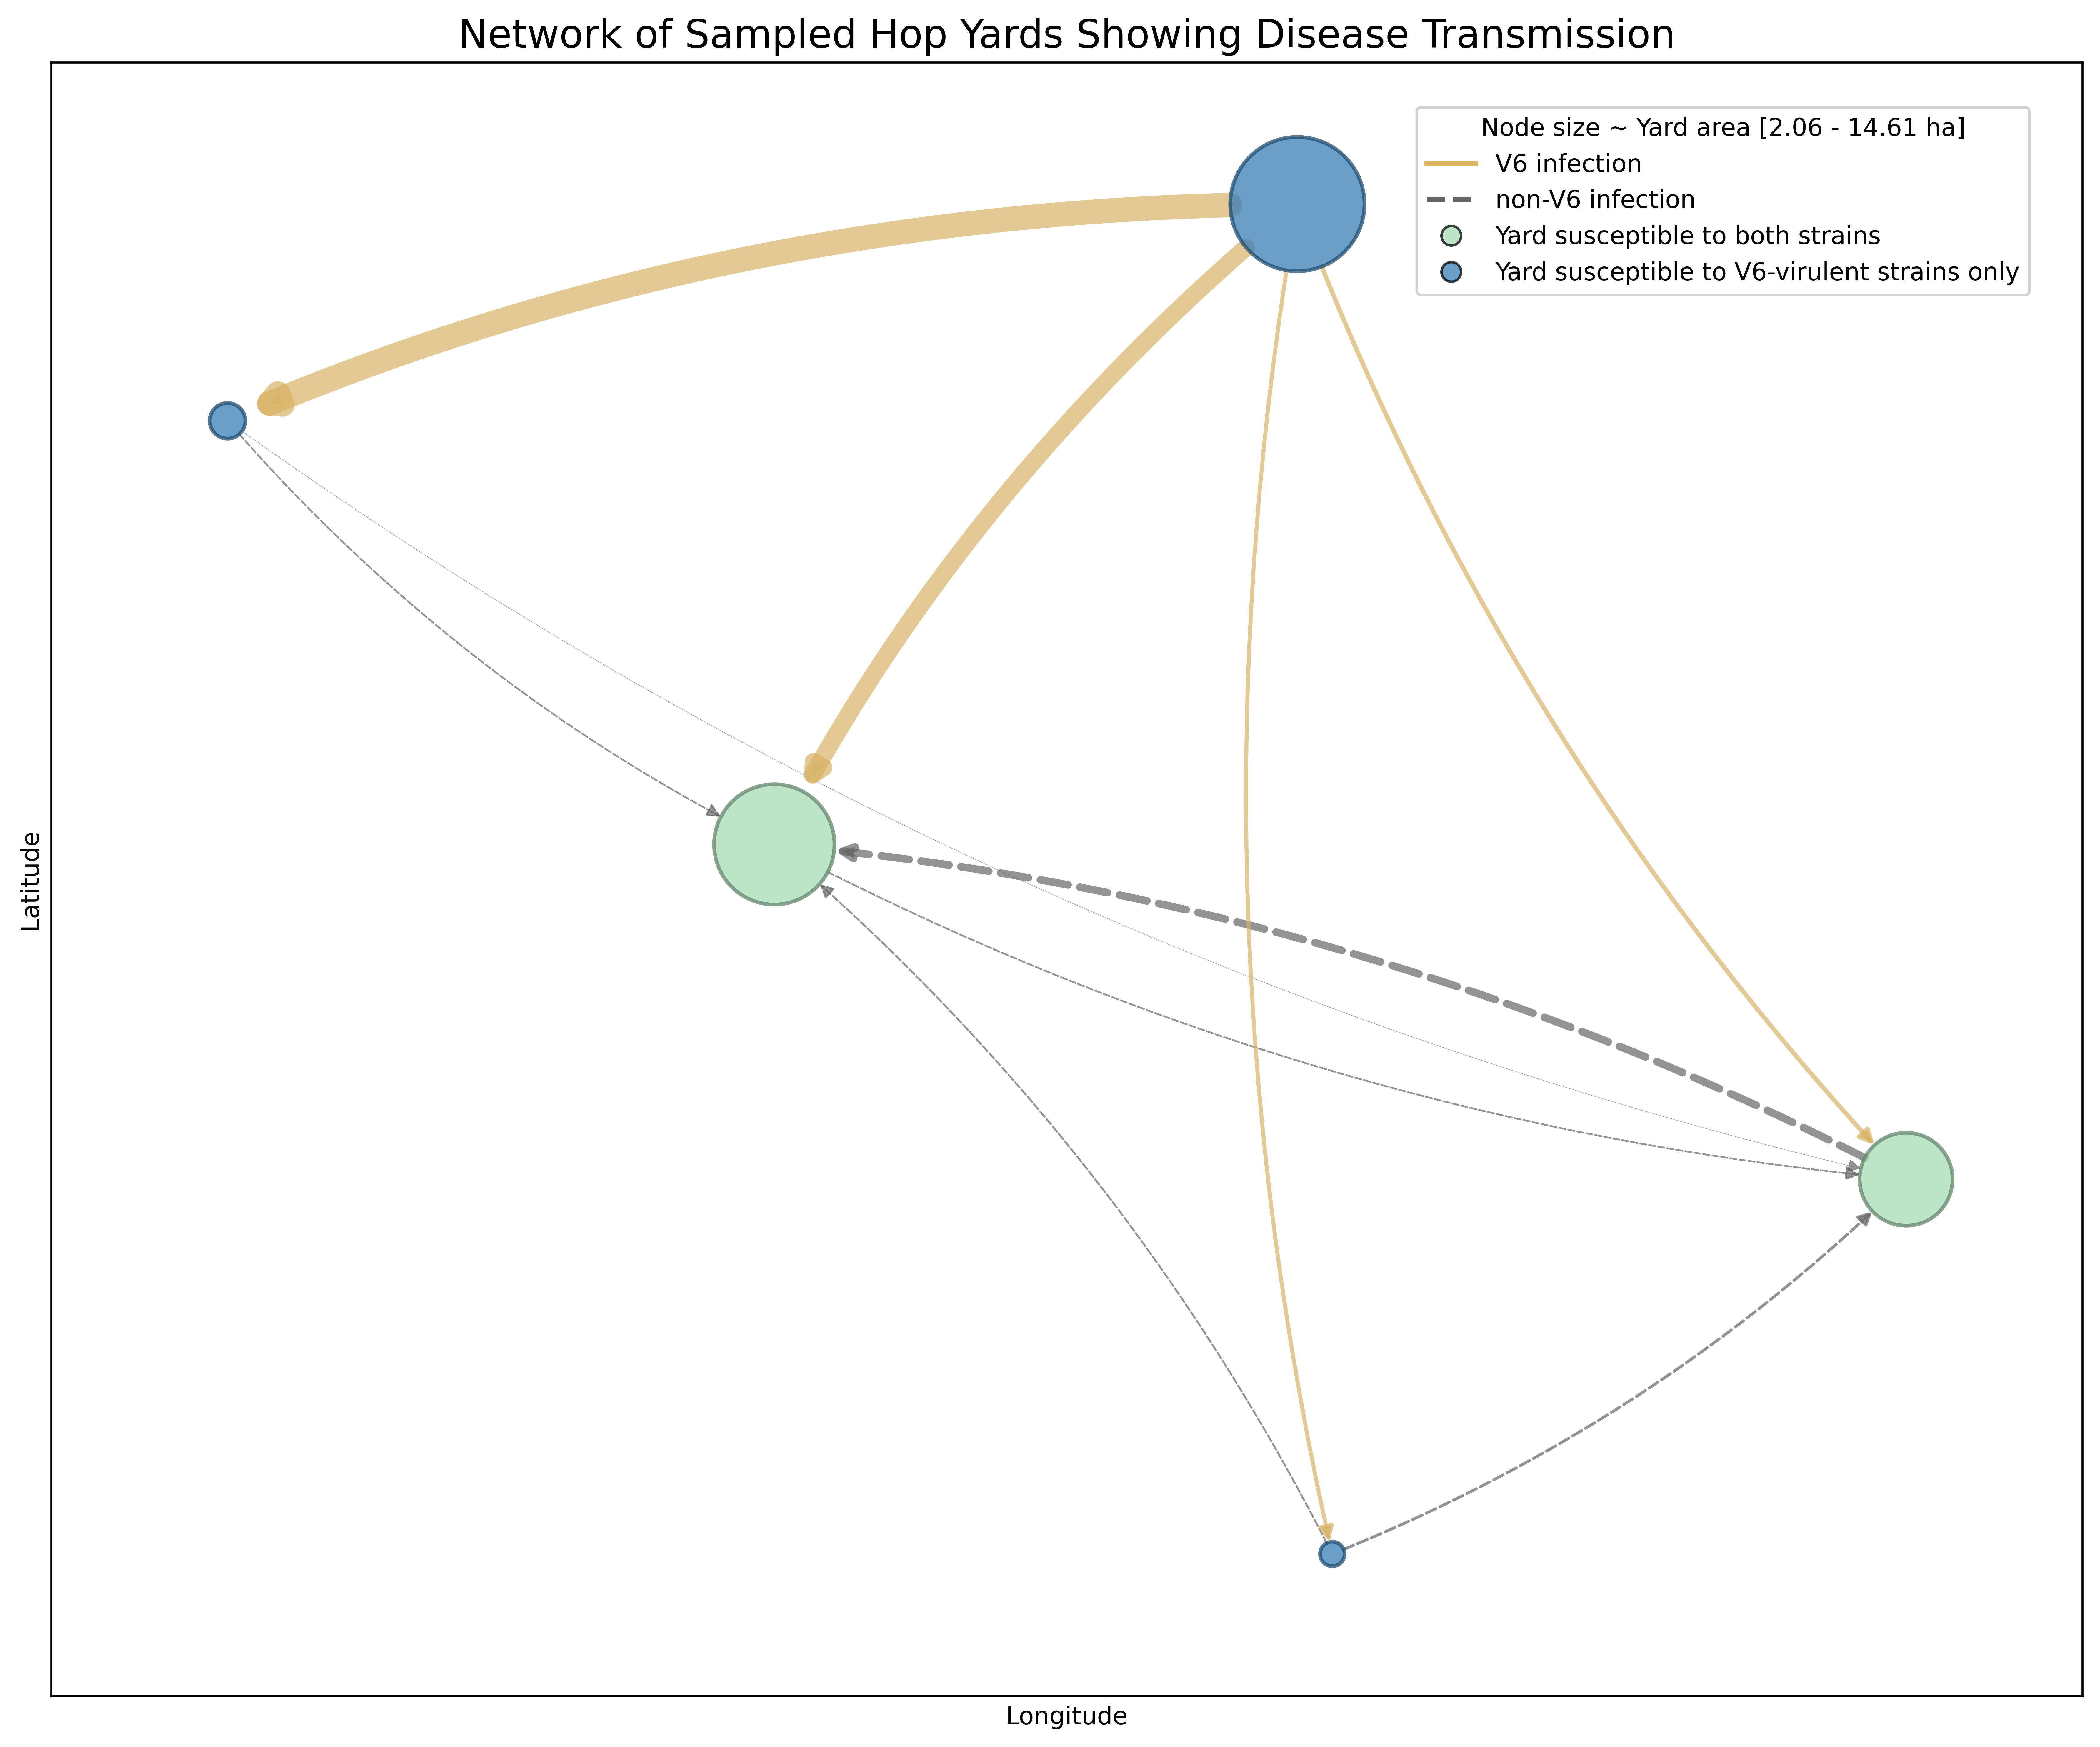

In [74]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors # Ensure this is imported
from matplotlib.colors import to_rgba # Import for color conversion
import numpy as np
import math # Needed for checking isnan
import pandas as pd # Ensure pandas is imported

# ==============================================================================
# Network Visualization for Sampled Nodes (One per *Other* Centrality Quantile) # <<< UPDATED
# - Node size ~ Area (area_hectares)
# - Edge width ~ Directed Weight (Area*Wind*Dist^-2) from new DiGraph G [LINEAR SCALING]
# - Enhanced Node Appearance (Transparency + Darker Border)
# ==============================================================================

# --- Parameters ---
LAYOUT_SEED = 21
MIN_NODE_SIZE = 100
MAX_NODE_SIZE = 3000
MIN_EDGE_WIDTH = 0.2
MAX_EDGE_WIDTH = 10.0

# --- Edge Color Parameters ---
base_color_sI1_rgba = to_rgba('#d8b365')  # Color for edges where source sI=1
base_color_sI0_rgba = to_rgba('#666666')  # Color for edges where source sI=0

# --- Node Appearance Parameters ---
NODE_ALPHA = 0.75
NODE_BORDER_WIDTH = 1.5
NODE_BORDER_DARKEN_FACTOR = 0.6
# *** ADJUST APPEARANCE PARAMETERS AS NEEDED ***

# --- Assumes the following variables exist from your preceding code ---
# G:                 The NEW nx.DiGraph object. <<< IMPORTANT (Must be DiGraph)
# degree_centrality_df: DataFrame with 'Node', 'Centrality_quantile_norm'. <<< IMPORTANT COLUMN
# coord:             DataFrame with 'Centroid Lat', 'Centroid Long'.
# sI1_may:           Numpy array sI=0/1.
# tI1:               Numpy array or source tI=0/1.
# area_hectares:     Numpy array/list area.
# year:              (Optional) The year.
# num_quantiles:     (Optional but helpful for context) The number of quantiles.
#---------------------------------------------------------------------

# --- Check for prerequisite Directed Graph G ---
if 'G' not in locals() and 'G' not in globals(): raise NameError("Directed NetworkX graph 'G' not found.")
if not isinstance(G, nx.DiGraph): raise TypeError("Variable 'G' is not a NetworkX DiGraph object.")

print("\n--- Creating NetworkX graph for Sampled Nodes (1 per *Other* Centrality Quantile) ---") # <<< UPDATED

# --- 1. Sample One Node per *Other* Centrality Quantile Norm --- # <<< NEW SAMPLING LOGIC
if 'degree_centrality_df' not in locals() and 'degree_centrality_df' not in globals():
     raise NameError("DataFrame 'degree_centrality_df' not found.")
# <<< Ensure the correct normalized quantile column exists >>>
if 'Centrality_quantile_norm' not in degree_centrality_df.columns:
     raise KeyError("Column 'Centrality_quantile_norm' not found in degree_centrality_df. Ensure it was calculated.")

# Prepare DataFrame (ensure 'Node' is a column)
if 'Node' not in degree_centrality_df.columns:
     if degree_centrality_df.index.name == 'Node': degree_centrality_df_reset = degree_centrality_df.reset_index()
     else:
          print("WARN: 'Node' column not found..."); degree_centrality_df_reset = degree_centrality_df.reset_index()
          if not pd.api.types.is_numeric_dtype(degree_centrality_df_reset['index']): raise ValueError("Could not identify Node IDs.")
          degree_centrality_df_reset = degree_centrality_df_reset.rename(columns={'index': 'Node'})
else:
    degree_centrality_df_reset = degree_centrality_df.copy()

# --- Determine target quantile norm values ---
# Get unique norm values, sort descending
unique_norms = sorted(degree_centrality_df_reset['Centrality_quantile_norm'].unique(), reverse=True)
# Select every other value starting from the first (highest)
target_norm_values = unique_norms[::2] # Slice with step 2
print(f"Targeting quantile norm values for sampling: {target_norm_values}")

# --- Filter DataFrame to include only target quantiles ---
filtered_df = degree_centrality_df_reset[
    degree_centrality_df_reset['Centrality_quantile_norm'].isin(target_norm_values)
]

if filtered_df.empty:
     print("WARN: No nodes found matching the target quantile norm values. Cannot sample.")
     exit()

# --- Group by the target norm values and sample 1 from each ---
print(f"Sampling 1 node from each of the {len(target_norm_values)} targeted quantiles using seed {LAYOUT_SEED}...")
sampled_df = filtered_df.groupby('Centrality_quantile_norm', observed=True).sample(n=1, random_state=LAYOUT_SEED)
sampled_node_ids = sampled_df['Node'].tolist()
# --- End of New Sampling Logic ---


if not sampled_node_ids:
    print("WARN: No nodes were sampled (unexpected). Cannot create graph.")
    exit()
else:
    print(f"Sampled {len(sampled_node_ids)} nodes.")

# --- [Step 2: Attribute Extraction - Remains the Same] ---
# (Code for extracting pos, sI, tI, area, centrality for sampled_node_ids is identical)
# ... (Attribute extraction code runs here) ...
# --- [Step 2: Attribute Extraction - Remains the Same] ---
print("Extracting attributes...")
if not coord.index.name == 'Node':
     if 'Node' in coord.columns: coord = coord.set_index('Node')
     elif coord.index.equals(pd.RangeIndex(len(coord))): print("WARN: Assuming coord index == Node ID."); coord.index.name = 'Node'
     else: raise ValueError("Cannot determine Node IDs in 'coord'.")
sampled_coord = coord.loc[sampled_node_ids]; pos = {nid: (r['Centroid Long'], r['Centroid Lat']) for nid, r in sampled_coord.iterrows()}
target_sI, target_tI, target_areas, target_centrality = {}, {}, {}, {}
try: tI1_flat=tI1.flatten(); tI1_dict={i: tI1_flat[i] for i in range(len(tI1_flat))}
except NameError: raise NameError("'tI1' not found.")
except Exception as e: raise TypeError(f"Could not convert tI1: {e}")
original_sampled_ids = sampled_node_ids.copy(); valid_sampled_node_ids = []
for node_id in original_sampled_ids:
    try:
        target_sI[node_id]=int(sI1_may[node_id][0] if sI1_may.ndim>1 else sI1_may[node_id])
        target_tI[node_id]=int(tI1_dict.get(node_id, np.nan))
        target_areas[node_id]=float(area_hectares[node_id][0] if area_hectares.ndim>1 else area_hectares[node_id])
        valid_sampled_node_ids.append(node_id)
    except Exception as e: print(f"WARN: Error attributes node {node_id}: {e}. Skipping.");
    if node_id in pos and node_id not in valid_sampled_node_ids: del pos[node_id]
sampled_node_ids=valid_sampled_node_ids;
# Get centrality from the FULL df initially used for sampling, before filtering/grouping, to ensure we have it.
target_centrality=degree_centrality_df_reset[degree_centrality_df_reset['Node'].isin(sampled_node_ids)].set_index('Node')['Centrality'].to_dict()
sampled_node_ids=[nid for nid in sampled_node_ids if nid in target_centrality] # Final check for centrality
if not sampled_node_ids: print("ERROR: No nodes remaining."); exit()


# --- [Step 3: Create Graph - Remains the Same] ---
G_sampled = nx.DiGraph()
# ... (Node addition loop is the same) ...
nodes_added_count = 0
for node_id in sampled_node_ids:
    node_area = target_areas.get(node_id, np.nan); node_centrality = target_centrality.get(node_id, np.nan)
    node_sI = target_sI.get(node_id, None); node_tI = target_tI.get(node_id, None)
    is_area_valid = isinstance(node_area, (int, float)) and not math.isnan(node_area) and node_area >= 0
    is_centrality_valid = isinstance(node_centrality, (int, float)) and not math.isnan(node_centrality)
    if not is_area_valid: node_area = 0.0
    if node_sI is None or node_tI is None or not is_centrality_valid: print(f"WARN: Node {node_id} missing critical attribute. Skipping add."); continue
    G_sampled.add_node(node_id, sI=node_sI, tI=node_tI, area=node_area, centrality=node_centrality)
    nodes_added_count += 1
print(f"Added {nodes_added_count} nodes to the sampled graph.")


# --- [Step 4: Add Edges - Remains the Same] ---
edge_weights_in_sample = []
# ... (Edge addition loop fetching directed weight from G is the same) ...
if nodes_added_count >= 2:
    print("Adding edges between sampled nodes based on sI/tI logic...")
    print("   Fetching DIRECTED edge weights from the new graph 'G'...")
    edges_added_count = 0
    for i in G_sampled.nodes():
        for j in G_sampled.nodes():
            if i == j: continue
            node_i_sI = G_sampled.nodes[i]['sI']; node_j_tI = G_sampled.nodes[j]['tI']
            if node_i_sI == 1 or (node_i_sI == 0 and node_j_tI == 0):
                directed_weight_ij = 0.0
                if G.has_edge(i, j):
                    edge_data = G.get_edge_data(i, j)
                    if edge_data and 'weight' in edge_data:
                         weight_val = edge_data['weight']
                         if isinstance(weight_val, (int, float)) and not math.isnan(weight_val) and weight_val >= 0: directed_weight_ij = weight_val
                         else: print(f"WARN: Invalid weight for edge {i}->{j} in G ({weight_val}). Using 0.")
                    else: print(f"WARN: Edge ({i}->{j}) found in G but missing 'weight'. Using 0.")
                G_sampled.add_edge(i, j, weight=directed_weight_ij); edge_weights_in_sample.append(directed_weight_ij); edges_added_count += 1
    print(f"Added {edges_added_count} directed edges to sampled graph.")
else: print("Skipping edge creation.");


# --- [Step 5: Visualize - Calculation Logic Remains the Same, Title Updated] ---
print("Visualizing the sampled network...")
# ... (Node size calculation code is the same) ...
node_sizes = []; areas_in_sample=[d['area'] for n,d in G_sampled.nodes(data=True)]; valid_areas=[a for a in areas_in_sample if isinstance(a,(int,float)) and not math.isnan(a) and a>=0]
if not valid_areas: min_area,max_area=0.0,0.0
else: min_area=min(valid_areas); max_area=max(valid_areas)
area_range=max_area-min_area; print(f"Areas in sample range: {min_area:.2f}-{max_area:.2f} ha."); default_size=(MIN_NODE_SIZE+MAX_NODE_SIZE)/2
for node_id in G_sampled.nodes():
    area = G_sampled.nodes[node_id].get('area', 0.0)
    if area_range > 1e-9: scaled_size=MIN_NODE_SIZE+max(0.0,min(1.0,(area-min_area)/area_range))*(MAX_NODE_SIZE-MIN_NODE_SIZE)
    else: scaled_size=default_size
    node_sizes.append(max(MIN_NODE_SIZE, scaled_size))

# ... (Node color calculation code is the same) ...
node_fill_colors, node_border_colors = [], []; print("Calculating node fill/border colors...")
for node_id in G_sampled.nodes():
     node_tI=G_sampled.nodes[node_id]['tI']; fill_color_hex='#CCCCCC'
     if node_tI==0: fill_color_hex='#a8ddb5'
     elif node_tI==1: fill_color_hex='#377eb8'
     node_fill_colors.append(fill_color_hex)
     try: rgb_fill=mcolors.to_rgb(fill_color_hex); rgb_border=tuple(max(0.0,c*NODE_BORDER_DARKEN_FACTOR) for c in rgb_fill); node_border_colors.append(rgb_border)
     except ValueError: print(f"WARN: Invalid fill color {fill_color_hex}."); node_border_colors.append((0,0,0))

# ... (Edge styling - color/style and LINEAR width scaling - code is the same) ...
edge_rgba_colors, edge_widths, edge_styles = [], [], []
if G_sampled.number_of_edges() > 0:
    print("Calculating edge styles and colors based on sI...")
    for u, v, data in G_sampled.edges(data=True):
        alpha=0.7; source_sI=G_sampled.nodes[u]['sI']
        if source_sI==1: base_color, style = base_color_sI1_rgba, 'solid'
        elif source_sI==0: base_color, style = base_color_sI0_rgba, 'dashed'
        else: base_color, style = to_rgba('#FF00FF'), 'dotted'
        edge_styles.append(style); edge_rgba_colors.append((base_color[0], base_color[1], base_color[2], alpha))

    print("Scaling edge widths linearly based on directed weight...")
    valid_weights = [w for w in edge_weights_in_sample if isinstance(w, (int, float)) and not math.isnan(w) and w >= 0]
    if not valid_weights: min_weight, max_weight = 0.0, 0.0
    else: min_weight = min(valid_weights); max_weight = max(valid_weights)
    weight_range = max_weight - min_weight
    print(f"Directed weights range: {min_weight:.4f} to {max_weight:.4f}.")
    default_width = (MIN_EDGE_WIDTH + MAX_EDGE_WIDTH) / 2.0
    for weight in edge_weights_in_sample:
         if not isinstance(weight, (int, float)) or math.isnan(weight) or weight < 0: edge_widths.append(MIN_EDGE_WIDTH); continue
         if weight_range > 1e-9:
             normalized_weight = max(0.0, min(1.0, (weight - min_weight) / weight_range))
             scaled_width = MIN_EDGE_WIDTH + normalized_weight * (MAX_EDGE_WIDTH - MIN_EDGE_WIDTH)
         else: scaled_width = default_width if min_weight > 1e-9 else MIN_EDGE_WIDTH
         edge_widths.append(max(MIN_EDGE_WIDTH, scaled_width))
    if len(edge_widths)!=G_sampled.number_of_edges() or len(edge_rgba_colors)!=G_sampled.number_of_edges() or len(edge_styles)!=G_sampled.number_of_edges(): raise ValueError("Mismatch edge lists!")
else: min_weight, max_weight = 0.0, 0.0


# --- Draw the sampled network ---
plt.figure(figsize=(12, 10), dpi=600)
# ... (Position validation is the same) ...
valid_pos = {node: pos[node] for node in G_sampled.nodes() if node in pos}
if len(valid_pos) != G_sampled.number_of_nodes(): print(f"WARN: Position data missing...")

# ... (Node drawing is the same) ...
nx.draw_networkx_nodes(G_sampled, valid_pos, node_color=node_fill_colors, node_size=node_sizes, alpha=NODE_ALPHA, linewidths=NODE_BORDER_WIDTH, edgecolors=node_border_colors)
# ... (Edge drawing is the same) ...
if G_sampled.number_of_edges() > 0: nx.draw_networkx_edges(G_sampled, valid_pos, edge_color=edge_rgba_colors, style=edge_styles, width=edge_widths, arrowstyle='-|>', arrowsize=12, node_size=node_sizes, connectionstyle='arc3,rad=0.1')
else: print("No edges to draw.")

# (Labels removed)
# (Legend remains the same)
# ... (Legend code is the same) ...
legend_elements = [plt.Line2D([0],[0],color='#d8b365',lw=2,label='V6 infection',ls='solid'), plt.Line2D([0],[0],color='#666666',lw=2,label='non-V6 infection',ls='dashed'), plt.Line2D([0],[0],marker='o',ms=8,mfc='#a8ddb5',mec='black',alpha=NODE_ALPHA,label='Yard susceptible to both strains',ls='None'), plt.Line2D([0],[0],marker='o',ms=8,mfc='#377eb8',mec='black',alpha=NODE_ALPHA,label='Yard susceptible to V6-virulent strains only',ls='None')]
leg = plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.98), fontsize=10, frameon=True)
leg.get_frame().set_alpha(0.9)
leg.get_frame().set_facecolor('white')
leg.set_title(f"Node size ~ Yard area [{min_area:.2f} - {max_area:.2f} ha]", prop={'size':10})


# <<< MODIFIED Title to reflect new sampling method >>>
# title_str = f"Network of Sampled Nodes (1 per Other Centrality Quantile Norm, Seed={LAYOUT_SEED})\n" # <<< UPDATED
# title_str += f"(Node Size ~ Area [{min_area:.2f}-{max_area:.2f} ha], "
# if G_sampled.number_of_edges() > 0 : title_str += f"Edge Width ~ Directed Physical Weight [{min_weight:.3f}-{max_weight:.3f}])"
# else: title_str += "Edge Width ~ Directed Physical Weight [No Edges])"
plt.title('Network of Sampled Hop Yards Showing Disease Transmission', fontsize=16)


plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()

# Save the figure before showing it
plt.savefig('../reports/figures/network_sampled_nodes_centrality_quantiles.png', 
            dpi=300, bbox_inches='tight', facecolor='white')

plt.show()

# --- End of Network Visualization ---

In [67]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba # Import for color conversion
import numpy as np
import math # Needed for checking isnan

# ==============================================================================
# Network Visualization for Target Cluster using Real Data
# ==============================================================================

# --- Parameters for Network Simulation ---
PLANTS_PER_YARD = 400
INFECTION_PROB = 0.02 # Binomial probability for infection simulation
                      # *** ADJUST THIS PROBABILITY AS NEEDED ***
LAYOUT_SEED = 123     # Seed for layout reproducibility

# --- Parameters for Node Size Scaling ---
MIN_NODE_SIZE = 100  # Minimum visual size of a node in pixels
MAX_NODE_SIZE = 3000 # Maximum visual size of a node in pixels
                     # *** ADJUST MIN/MAX SIZES AS NEEDED ***

# --- Assumes the following variables exist from your preceding code ---
# target_cluster_df: DataFrame filtered for the highest centrality cluster,
#                    containing 'Node', 'Centroid Lat', 'Centroid Long', 'tI1'.
# sI1_may:           The full (Nx1 or Nx?) numpy array containing sI=0/1 for all yards.
# area_hectares:     The full (Nx1 or N,) numpy array/list with area for all yards.
# highest_centrality_cluster_label: The label of the target cluster.
#---------------------------------------------------------------------

print(f"\n--- Creating NetworkX graph for Target Cluster {highest_centrality_cluster_label} ---")

# --- 1. Extract Data for Target Cluster Nodes ---
target_node_ids = target_cluster_df['Node'].tolist()
if not target_node_ids:
    print(f"WARN: Target cluster {highest_centrality_cluster_label} has no nodes. Skipping network visualization.")
else:
    # Create position dictionary {node_id: (lon, lat)}
    pos = {row['Node']: (row['Centroid Long'], row['Centroid Lat'])
           for index, row in target_cluster_df.iterrows()} # Corrected line

    # Create attribute dictionaries for target nodes
    try:
        # Assuming sI1_may might be (N, 1) or just (N,)
        target_sI = {node_id: int(sI1_may[node_id][0] if sI1_may.ndim > 1 else sI1_may[node_id])
                     for node_id in target_node_ids}
    except IndexError as e:
         raise IndexError(f"Error accessing sI1_may for node IDs. Check shape/indexing. Original error: {e}")

    target_tI = target_cluster_df.set_index('Node')['tI1'].astype(int).to_dict()

    # *** NEW: Extract areas for target nodes ***
    try:
        # Assuming area_hectares might be (N, 1) or just (N,)
        target_areas = {node_id: float(area_hectares[node_id][0] if area_hectares.ndim > 1 else area_hectares[node_id])
                        for node_id in target_node_ids}
    except IndexError as e:
         raise IndexError(f"Error accessing area_hectares for node IDs. Check shape/indexing. Original error: {e}")
    except TypeError as e:
         raise TypeError(f"Error converting area_hectares to float. Check data type. Original error: {e}")


    # --- 2. Create the Directed Graph ---
    G_target = nx.DiGraph()

    # Add nodes with attributes (sI, tI, and now area)
    for node_id in target_node_ids:
        G_target.add_node(node_id,
                          sI=target_sI[node_id],
                          tI=target_tI[node_id],
                          area=target_areas.get(node_id, 0.0)) # Store area attribute too
    print(f"Added {G_target.number_of_nodes()} nodes to the target graph.")

    # --- 3. Add Edges and Calculate Weights based on Infection Logic ---
    # (This section remains the same as before)
    print("Calculating edges and weights based on infection logic and simulation...")
    edge_count = 0
    simulated_weights = []
    for i in target_node_ids:
        for j in target_node_ids:
            if i == j: continue
            if target_sI[i] == 1 or (target_sI[i] == 0 and target_tI[j] == 0):
                infections_i = np.random.binomial(n=PLANTS_PER_YARD, p=INFECTION_PROB)
                infections_j = np.random.binomial(n=PLANTS_PER_YARD, p=INFECTION_PROB)
                total_infections = infections_i + infections_j
                total_plants_between = 2 * PLANTS_PER_YARD
                weight = total_infections / float(total_plants_between) if total_plants_between > 0 else 0.0
                weight = max(0.0, min(1.0, weight))
                G_target.add_edge(i, j, weight=weight)
                simulated_weights.append(weight)
                edge_count += 1
    # (Min/Max weight calculation remains the same)
    print(f"Added {edge_count} edges to the target graph.")
    if not simulated_weights: min_weight, max_weight, weight_range = 0.0, 0.0, 0.0
    else:
        min_weight = min(simulated_weights); max_weight = max(simulated_weights)
        weight_range = max_weight - min_weight
    print(f"Simulated edge weights range from {min_weight:.4f} to {max_weight:.4f}.")


    # --- 4. Visualize the Network ---
    print("Visualizing the target cluster network with node size scaled by area and dashed edges for sI=0...")

    if not G_target.nodes:
        print("Graph has no nodes. Cannot visualize.")
        # Exit or return if G_target is empty

    # --- Node Colors (based on tI) ---
    node_colors = ['#a8ddb5' if G_target.nodes[i]['tI'] == 0 else '#377eb8' for i in G_target.nodes()]

    # --- Calculate Scaled Node Sizes (based on area) ---
    # (This part remains the same as before)
    node_sizes = []
    areas_in_cluster = [data['area'] for node, data in G_target.nodes(data=True)]
    if not areas_in_cluster: min_area, max_area = 0.0, 0.0
    else: min_area = min(areas_in_cluster); max_area = max(areas_in_cluster)
    area_range = max_area - min_area
    print(f"Areas in target cluster range from {min_area:.2f} to {max_area:.2f} hectares.")
    default_size = (MIN_NODE_SIZE + MAX_NODE_SIZE) / 2
    for node_id in G_target.nodes():
        area = G_target.nodes[node_id].get('area', 0)
        if area_range > 1e-9: scaled_size = MIN_NODE_SIZE + ((area - min_area) / area_range) * (MAX_NODE_SIZE - MIN_NODE_SIZE)
        else: scaled_size = default_size
        node_sizes.append(max(MIN_NODE_SIZE, scaled_size))

    # --- Edge styling (Calculate colors, widths, AND styles) ---
    edge_rgba_colors = []
    base_color_sI1_rgba = to_rgba('#d8b365')
    base_color_sI0_rgba = to_rgba('#666666')
    edge_widths = []
    edge_styles = [] # *** NEW: List to store edge styles ***

    # Iterate through edges to determine style, color, width, alpha based on source node and weight
    for u, v, data in G_target.edges(data=True):
        weight = data.get('weight', 0.0)

        # Calculate alpha (opacity) based on weight (quadratic scaling)
        alpha = 0.0
        if weight_range > 1e-9:
            normalized_weight = max(0.0, min(1.0, (weight - min_weight) / weight_range))
            alpha = (normalized_weight ** 2) * 0.9
        elif max_weight > 1e-9: alpha = 0.9 if weight == max_weight else 0.0
        alpha = max(0.0, min(0.9, alpha))

        # Determine width
        edge_widths.append(0.8 + alpha * 1.2)

        # Determine base color and style based on source node's sI
        if G_target.nodes[u]['sI'] == 1:
            base_color = base_color_sI1_rgba
            edge_styles.append('solid') # *** sI=1 -> solid style ***
        else: # sI == 0
            base_color = base_color_sI0_rgba
            edge_styles.append('dashed') # *** sI=0 -> dashed style ***

        # Append RGBA color tuple
        edge_rgba_colors.append((base_color[0], base_color[1], base_color[2], alpha))

    arrowstyles = [ '-|>' for _ in G_target.edges()]

    # --- Draw the network ---
    plt.figure(figsize=(18, 10), dpi=600)

    # Draw nodes
    nx.draw_networkx_nodes(G_target, pos, node_color=node_colors, node_size=node_sizes)

    # Draw edges - *** MODIFIED: Added style parameter ***
    nx.draw_networkx_edges(G_target, pos, edge_color=edge_rgba_colors,
                           style=edge_styles, # <-- Pass the list of styles
                           arrowstyle=arrowstyles,
                           width=edge_widths,
                           arrowsize=12,
                           node_size=node_sizes, # IMPORTANT for edge clipping
                           connectionstyle='arc3,rad=0.1')

    # --- Labels are removed (as per previous request) ---
    # nx.draw_networkx_labels(...)

    # --- Create custom legend - *** MODIFIED: Updated sI=0 line style *** ---
    legend_elements = [
        plt.Line2D([0], [0], color='#d8b365', lw=2, label='Edge: Source sI=1 (Infects All)', linestyle='solid'), # Explicitly solid
        plt.Line2D([0], [0], color='#666666', lw=2, label='Edge: Source sI=0 (Infects tI=0)', linestyle='dashed'), # Changed to dashed
        plt.Line2D([0], [0], marker='o', markersize=8, markerfacecolor='#a8ddb5', markeredgecolor='black', label='Node: tI=0', linestyle='None'),
        plt.Line2D([0], [0], marker='o', markersize=8, markerfacecolor='#377eb8', markeredgecolor='black', label='Node: tI=1', linestyle='None'),
    ]
    leg = plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.98), fontsize=10, frameon=True)
    leg.get_frame().set_alpha(0.9)
    leg.get_frame().set_facecolor('white')
    leg.set_title(f"Node size ~ Area [{min_area:.2f}-{max_area:.2f} ha]", prop={'size':10})

    # (Title, labels, layout, show remain the same)
    plt.title(f"Target Cluster {highest_centrality_cluster_label} Network (Node Size ~ Area, {INFECTION_PROB=:.3f})\n(Quadratic Opacity [0.0-0.9] for Weight [{min_weight:.3f}-{max_weight:.3f}])", fontsize=14)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.tight_layout()
    plt.show()

# --- End of Network Visualization ---


--- Creating NetworkX graph for Target Cluster 4 ---
Added 10 nodes to the target graph.
Calculating edges and weights based on infection logic and simulation...
Added 59 edges to the target graph.
Simulated edge weights range from 0.0088 to 0.0350.
Visualizing the target cluster network with node size scaled by area and dashed edges for sI=0...
Areas in target cluster range from 1.34 to 13.31 hectares.
